# Timeseries and Shapelet analysis

## Dataset preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


In [2]:
# Read in the data
final = pd.read_csv('../dataset/data/final_clean3.csv')



In [3]:
print(final.shape)
final.head()

(235219, 80)


date_year  date_month       state incident_characteristics1  \
0     2013.0           1  CALIFORNIA              SHOT_INJURED   
1     2013.0           1    COLORADO                 SHOT_DEAD   
2     2013.0           1   LOUISIANA              SHOT_INJURED   
3     2013.0           1   LOUISIANA              SHOT_INJURED   
4     2013.0           1    MARYLAND              SHOT_INJURED   

   congressional_district  date_day city_or_county  latitude  longitude  \
0                    43.0         1      Hawthorne   33.9090  -118.3330   
1                     6.0         5         Aurora   39.6518  -104.8020   
2                     2.0        21    New Orleans   29.9435   -90.0836   
3                     3.0        26      Charenton   29.8816   -91.5251   
4                     7.0        23      Baltimore   39.2899   -76.6412   

   min_age_participants  ...  cd_month_SHOT_DEAD  cd_month_NON_SHOOTING  \
0                  20.0  ...                 0.0                    0.0   
1                  29.0  ...                 1.0                    0.0   
2                  16.0  ...                 0.0                    0.0   
3                  48.0  ...                 0.0                    0.0   
4                  15.0  ...                 0.0                    0.0   

   cd_month_SHOTS_FIRED_UNHARMED  cd_month_OTHER  state_month_SHOT_INJURED  \
0                            0.0             0.0                       1.0   
1                            0.0             0.0                       0.0   
2                            0.0             0.0                       1.0   
3                            0.0             0.0                       1.0   
4                            0.0             0.0                       1.0   

   state_month_SHOT_DEAD  state_month_NON_SHOOTING  \
0                    0.0                       0.0   
1                    1.0                       0.0   
2                    0.0                       0.0   
3                    0.0                       0.0   
4                    0.0                       0.0   

   state_month_SHOTS_FIRED_UNHARMED  state_month_OTHER  non_workday  
0                               0.0                0.0            1  
1                               0.0                0.0            0  
2                               0.0                0.0            1  
3                               0.0                0.0            0  
4                               0.0                0.0            0  

[5 rows x 80 columns]

In [4]:
#In this cell, the code filters the final dataframe to include only accidents that occurred between 2014 and 2017. 
#The resulting dataframe is stored in final_wout_wrng_years.


#filter only for accidents between 2014 and 2017
final_wout_wrng_years = final[(final['date_year'] >= 2014) & (final['date_year'] <= 2017)].copy()


# New column with the week number
final_wout_wrng_years['week_number'] = (final_wout_wrng_years['timestamp']//7) - 208
final_wout_wrng_years['week_number'] = final_wout_wrng_years['week_number'].astype(int)

final_wout_wrng_years.head()

date_year  date_month    state incident_characteristics1  \
272     2014.0           1  ALABAMA             ARMED_ROBBERY   
273     2014.0           1  ALABAMA             ARMED_ROBBERY   
274     2014.0           1  ALABAMA             ARMED_ROBBERY   
275     2014.0           1  ALABAMA             ARMED_ROBBERY   
276     2014.0           1  ALABAMA             ARMED_ROBBERY   

     congressional_district  date_day city_or_county  latitude  longitude  \
272                     1.0        14         Mobile   30.7149   -88.0942   
273                     1.0        21         Mobile   30.6731   -88.0972   
274                     1.0         6         Mobile   30.6977   -88.1424   
275                     2.0        22      Millbrook   32.4673   -86.3604   
276                     3.0         2         Auburn   32.6088   -85.4505   

     min_age_participants  ...  cd_month_NON_SHOOTING  \
272                  18.0  ...               0.000000   
273                  17.0  ...               0.000000   
274                  16.0  ...               0.000000   
275                  16.0  ...               0.142857   
276                  43.0  ...               0.000000   

     cd_month_SHOTS_FIRED_UNHARMED  cd_month_OTHER  state_month_SHOT_INJURED  \
272                            0.1        0.500000                  0.293478   
273                            0.1        0.500000                  0.293478   
274                            0.1        0.500000                  0.293478   
275                            0.0        0.285714                  0.293478   
276                            0.0        0.333333                  0.293478   

     state_month_SHOT_DEAD  state_month_NON_SHOOTING  \
272               0.304348                  0.043478   
273               0.304348                  0.043478   
274               0.304348                  0.043478   
275               0.304348                  0.043478   
276               0.304348                  0.043478   

     state_month_SHOTS_FIRED_UNHARMED  state_month_OTHER  non_workday  \
272                          0.065217           0.293478            0   
273                          0.065217           0.293478            0   
274                          0.065217           0.293478            0   
275                          0.065217           0.293478            0   
276                          0.065217           0.293478            0   

     week_number  
272            2  
273            3  
274            1  
275            3  
276            0  

[5 rows x 81 columns]

In [5]:
#sort by week
city_df = final_wout_wrng_years.sort_values(by=['week_number']).copy()

new_df = city_df.groupby(['week_number', 'city_or_county']).size().reset_index(name='counts')

#pivot the table to have the cities as columns
pivot_df = new_df.pivot(index='week_number', columns='city_or_county', values='counts')

#fill the NaN values with 0
pivot_df = pivot_df.fillna(0)

pivot_df = pivot_df.astype(int)
pivot_df.head()

city_or_county  Abbeville  Abbotsford  Abbott  Abbott Township  Abbottstown  \
week_number                                                                   
0                       0           0       0                0            0   
1                       0           0       0                0            0   
2                       1           0       0                0            0   
3                       0           0       0                0            0   
4                       0           0       0                0            0   

city_or_county  Abercrombie  Aberdeen  Abilene  Abingdon  Abington  ...  Zion  \
week_number                                                         ...         
0                         0         0        0         0         0  ...     0   
1                         0         0        0         0         0  ...     0   
2                         0         1        0         0         0  ...     0   
3                         0         0        1         0         0  ...     0   
4                         0         0        0         0         0  ...     0   

city_or_county  Zion (Beach Park)  Zion Grove  Zionsville  Zionville  \
week_number                                                            
0                               0           0           0          0   
1                               0           0           0          0   
2                               0           0           0          0   
3                               0           0           0          0   
4                               0           0           0          0   

city_or_county  Zumbro Falls  Zumbrota  Zuni (Zuni Pueblo)  Zwolle  \
week_number                                                          
0                          0         0                   0       0   
1                          0         0                   0       0   
2                          0         0                   0       0   
3                          0         0                   0       0   
4                          0         0                   0       0   

city_or_county  jefferson parish (county)  
week_number                                
0                                       0  
1                                       0  
2                                       0  
3                                       0  
4                                       0  

[5 rows x 12509 columns]

In [6]:
# We now remove the columns with less week of incidents than 15% of 208 weeks
pivot_df = pivot_df.loc[:, (pivot_df.sum(axis=0) > 30)]
pivot_df

final_pivot = pivot_df.copy()

# Remove from city_df the cities that are not in the pivot_df
clean_city_df = city_df[city_df['city_or_county'].isin(final_pivot.columns)].copy()

# Return the city_or_county remaining
clean_city_df['city_or_county'].unique()



array(['Orlando', 'Philadelphia', 'Saint Petersburg', 'Tampa',
       'Morrisville', 'Baltimore', 'Erie', 'New Orleans', 'Clinton',
       'Greenacres', 'Manchester', 'Jacksonville', 'Miami Beach', 'Miami',
       'Crestview', 'Fort Walton Beach', 'Rock Hill', 'Greensboro',
       'Beaufort', 'Providence', 'Camden', 'Columbia', 'Hazleton',
       'New Brunswick', 'Washington', 'Marietta', 'Savannah', 'Laurel',
       'Allentown', 'Columbus', 'Lancaster', 'Albany', 'Warner Robins',
       'Atlanta', 'Homestead', 'Dover', 'Bossier City', 'Belleville',
       'Portsmouth', 'Hagerstown', 'Covington', 'Charleston', 'Killeen',
       'New Haven', 'Corpus Christi', 'Omaha', 'Minneapolis', 'Tucson',
       'Fall River', 'College Station', 'Amarillo', 'Fort Worth',
       'Nashville', 'Lubbock', 'Bridgeport', 'San Bernardino', 'Holyoke',
       'Houston', 'Kansas City', 'Port Arthur', 'Wilmington',
       'Fort Collins', 'Liberty', 'Colorado Springs', 'Denver', 'Pueblo',
       'El Paso', 'Gran

In [7]:
clean_city_df.groupby(['city_or_county'])["n_killed"].sum().sort_values(ascending=True)

city_or_county
Oil City (Caddo)       1.0
Meriden                1.0
Janesville             2.0
Fulton                 2.0
Framingham             2.0
                     ...  
Philadelphia         877.0
Saint Louis          904.0
Baltimore           1042.0
Houston             1169.0
Chicago             2093.0
Name: n_killed, Length: 790, dtype: float64

---

## Score Definition

In [8]:
# Our score function is defined as a weighted sum of various features of the dataset
# Defined in this way, our score is always a positive number
# The weights are chosen arbitrarily and can be changed based on the importance that we want to give to each feature
# we gave a higher weight to the number of killed and injured people, and a lower weight to the number of arrested people
# We also gave a higher weight to the number of children and teenagers involved in the incident, and a lower weight to the number of adults involved
# The score can be considered as a measure of the severity of the incident

def score(df: pd.DataFrame):
    return df['n_killed'].sum() + df['n_injured'].sum() * 0.8 + df['n_arrested'].sum() * 0.5 + df['n_participants_child'].sum() * 1 + df['n_participants_teen'].sum() * 0.8 + df['n_participants_adult'].sum() * 0.5

In [9]:
support_df = clean_city_df.copy()
support_df = support_df.set_index(['week_number','city_or_county'])

support_df['score'] = support_df.groupby(support_df.index.names).apply(score)

score_pivot = support_df.pivot_table(index='week_number', columns='city_or_county', values='score')
score_pivot = score_pivot.fillna(0)

score_pivot.head()

city_or_county  Abbeville  Aberdeen  Abilene  Aiken  Akron  Albany  \
week_number                                                          
0                     0.0       0.0      0.0    0.0    0.0     1.3   
1                     0.0       0.0      0.0    2.5    0.0     0.0   
2                     1.8       1.0      0.0    0.0    0.0    10.9   
3                     0.0       0.0      1.8    0.0    4.8     0.0   
4                     0.0       0.0      0.0    0.0    0.0     1.0   

city_or_county  Albert Lea  Albuquerque  Alexandria  Allentown  ...  \
week_number                                                     ...   
0                      0.0          1.3         0.0        0.5  ...   
1                      0.0          0.0         0.5        0.0  ...   
2                      0.0          0.0         2.0        2.8  ...   
3                      0.0          4.8         1.8        1.8  ...   
4                      0.0          1.5         0.0        1.8  ...   

city_or_county  Wisconsin Rapids  Woodbridge  Worcester  Wyoming  Yakima  \
week_number                                                                
0                            0.0         0.0        0.5      0.0     1.5   
1                            0.0         0.0        3.5      0.0     0.0   
2                            0.0         0.0        0.0      0.0     1.3   
3                            0.0         2.0        1.5      0.0     0.0   
4                            0.0         0.0        1.0      0.0     0.0   

city_or_county  Yonkers  York  Youngstown  Ypsilanti  Yuma  
week_number                                                 
0                   0.0   0.0         0.0        0.0   0.0  
1                   1.3   1.8         0.0        0.0   1.8  
2                   0.0   0.0         0.0        1.8   0.0  
3                   0.0   2.6         1.5        6.0   0.0  
4                   0.0   0.0         0.0        0.0   0.0  

[5 rows x 790 columns]

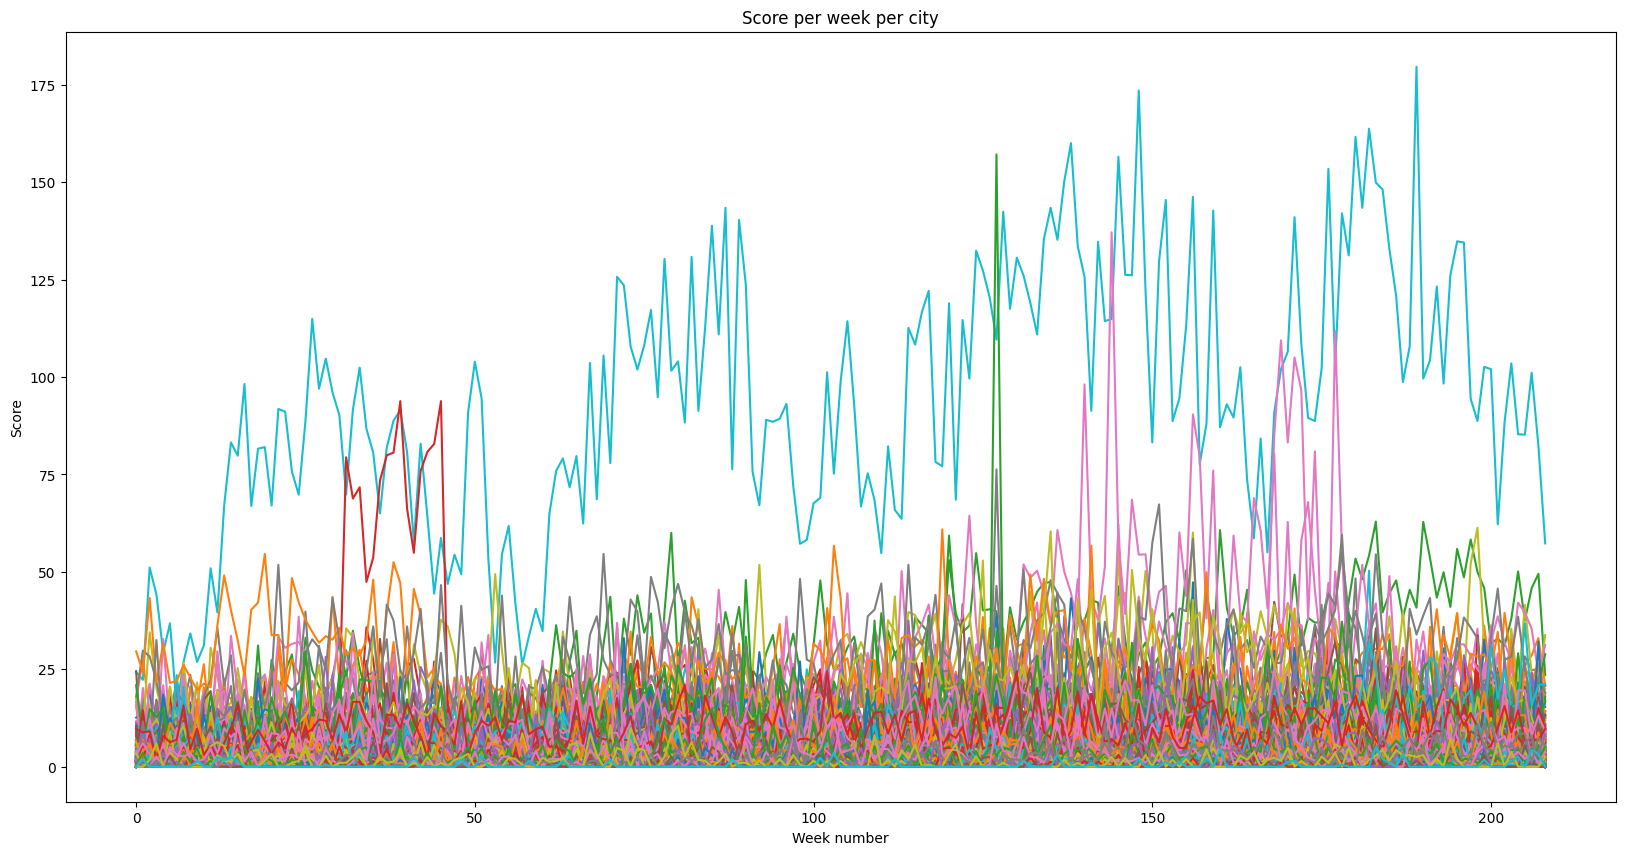

In [10]:

score_pivot.plot(figsize=(20,10), legend=False)
plt.title('Score per week per city')
plt.xlabel('Week number')
plt.ylabel('Score')
plt.show()

In [11]:
#show the 5 cities with the highest score
score_pivot.sum(axis=0).sort_values(ascending=False).head(5)


city_or_county
Chicago         19571.8
Baltimore        6113.2
New Orleans      5335.8
Philadelphia     5293.5
Houston          5181.6
dtype: float64

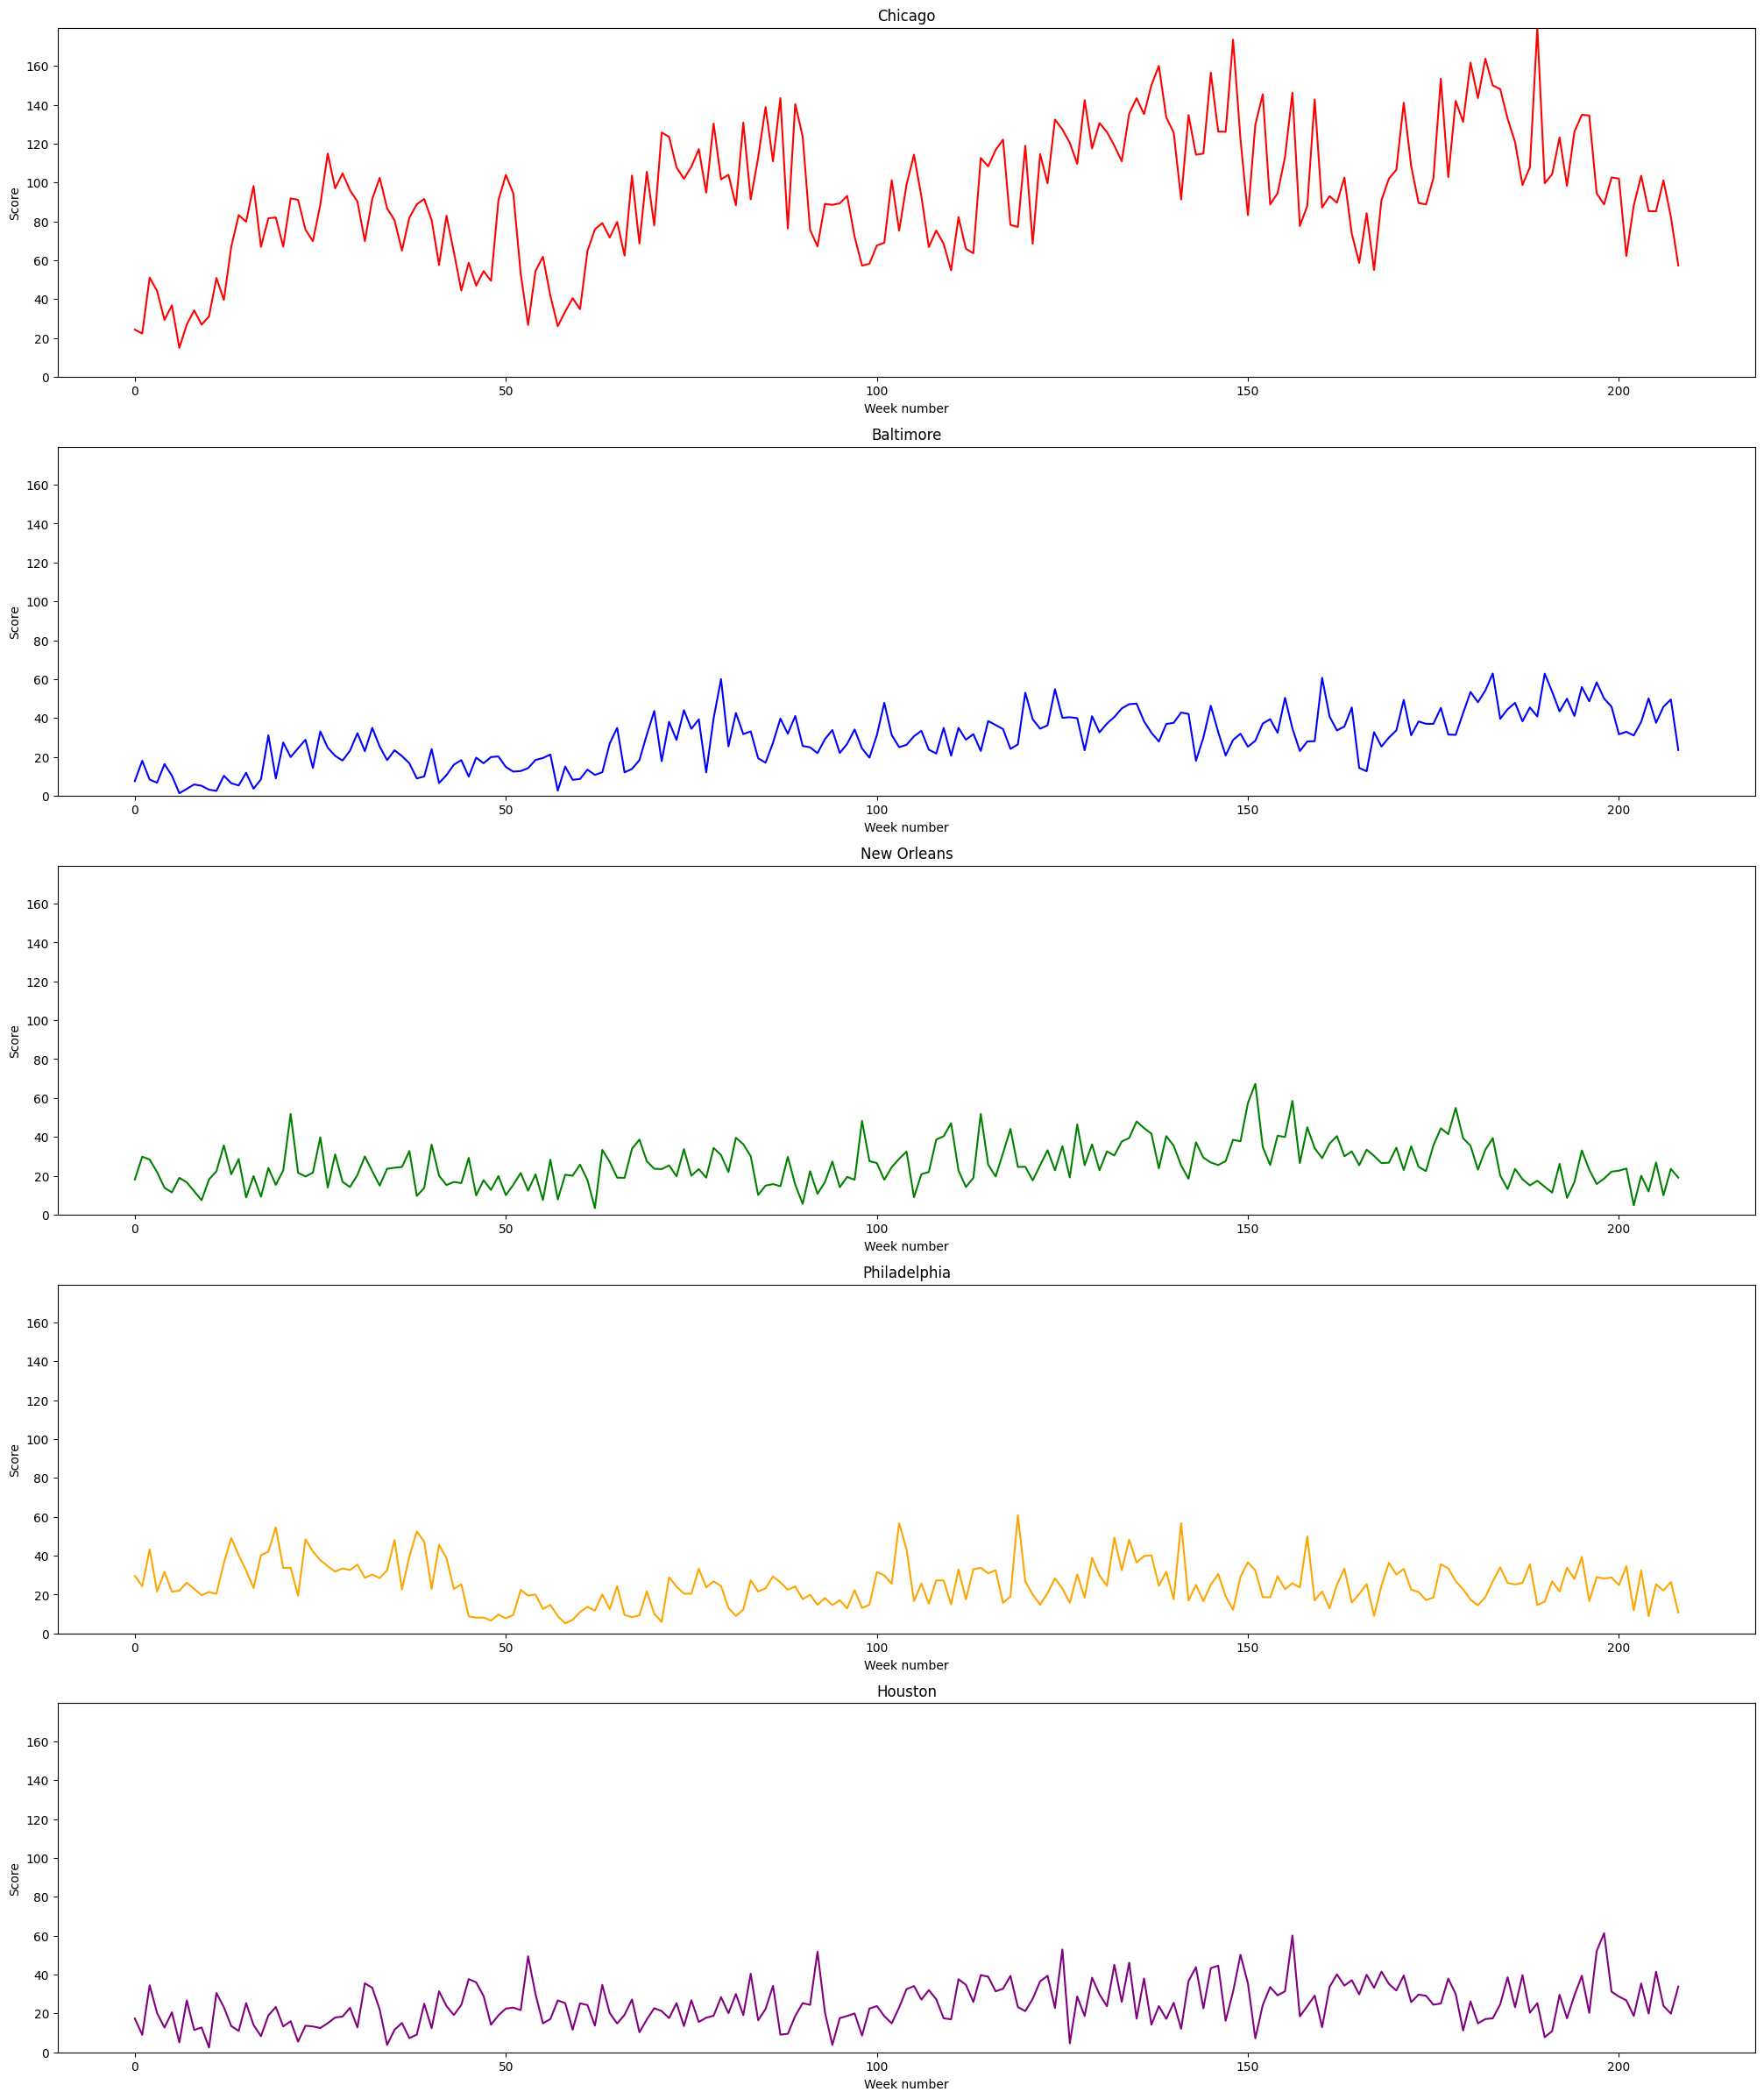

In [12]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(25, 30))
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, city in enumerate(['Chicago', 'Baltimore', 'New Orleans', 'Philadelphia', 'Houston']):
    score_pivot[city].plot(ax=axes[i], legend=False, color=colors[i])
    axes[i].set_title(city)
    axes[i].set_xlabel('Week number')
    axes[i].set_ylabel('Score')
    axes[i].set_ylim([score_pivot.min().min(), score_pivot.max().max()])  # Set the same y limit for all subplots

plt.show()




---

## Time Series Scaling

In [13]:
#create a dict containing the cities and the time series for the city
ts_dict = {}
for city in score_pivot.columns:
    ts_dict[city] = pd.Series(score_pivot[city])


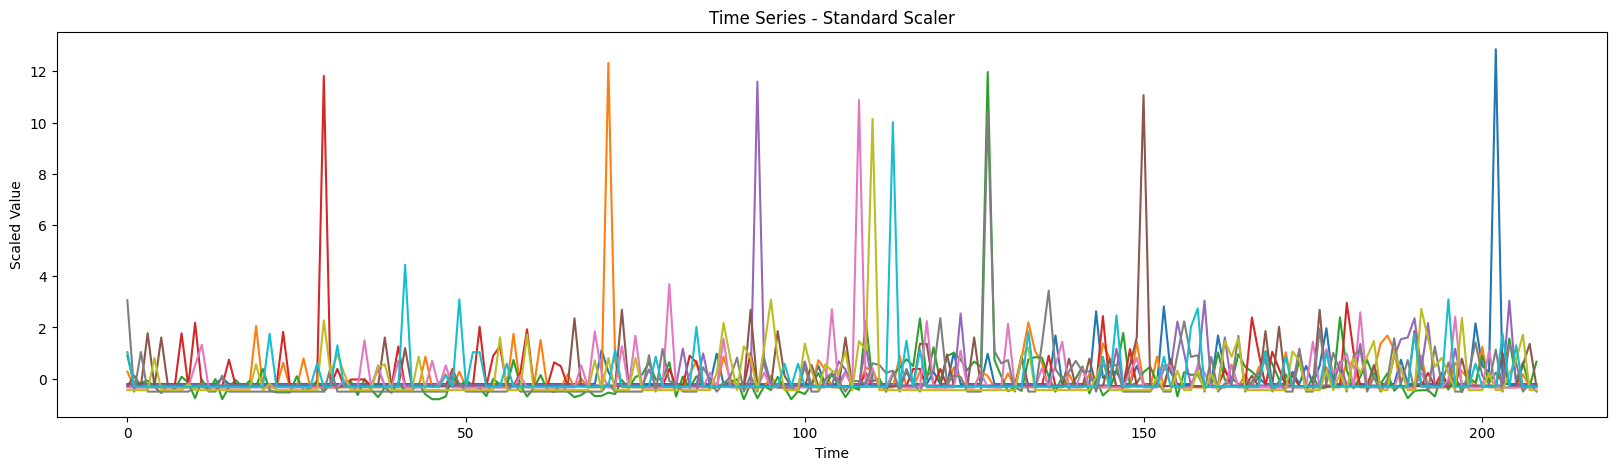

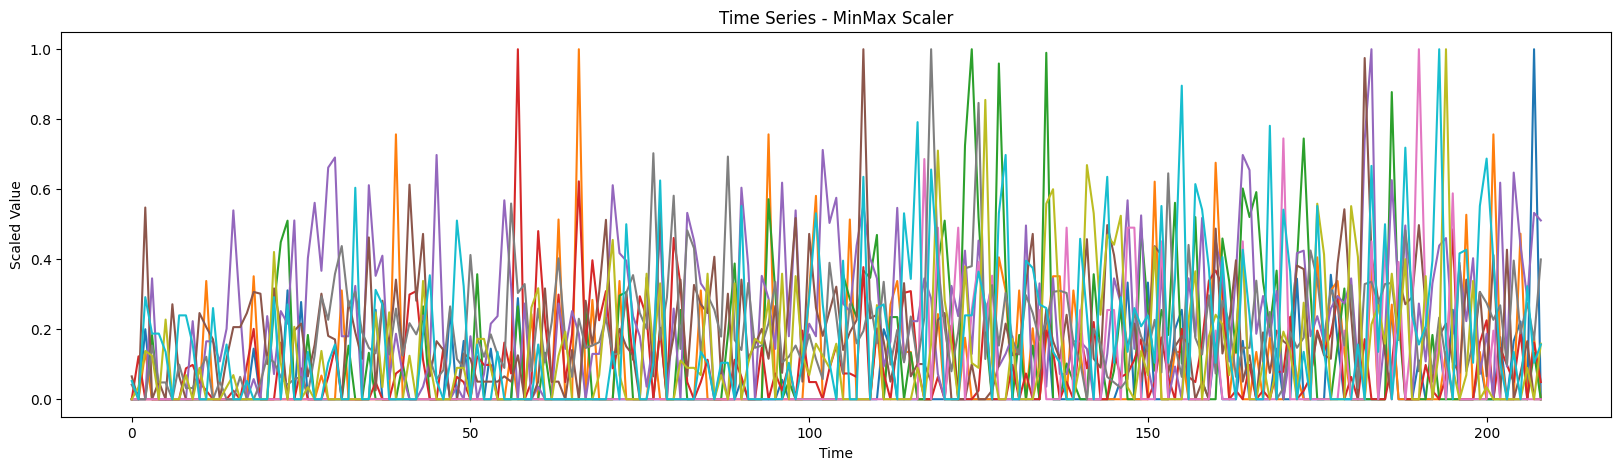

In [14]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.preprocessing import TimeSeriesScalerMinMax




#------------------------------------------------------------------------------------------
#Standard Scaler

scaler_mean = TimeSeriesScalerMeanVariance(mu=0, std=1)  

scaled_mean_ts_dict = {}
for city in ts_dict.keys():
    scaled_mean_ts_dict[city] = scaler_mean.fit_transform(ts_dict[city].values.reshape(1, -1)).flatten()




#------------------------------------------------------------------------------------------
#MinMax Scaler


scaler_minmax = TimeSeriesScalerMinMax(value_range=(0, 1))

scaled_minmax_ts_dict = {}
for city in ts_dict.keys():
    scaled_minmax_ts_dict[city] = scaler_minmax.fit_transform(ts_dict[city].values.reshape(1, -1)).flatten()





# Plot the time series from the scaled_mean_ts_dict dictionary
plt.figure(figsize=(20, 5))
for city, ts in sorted(scaled_mean_ts_dict.items(), key=lambda x: np.max(x[1]), reverse=True)[:10]:
    plt.plot(ts, label=city)
plt.title('Time Series - Standard Scaler')
plt.xlabel('Time')
plt.ylabel('Scaled Value')
plt.show()

# Plot the time series from the scaled_minmax_ts_dict dictionary
plt.figure(figsize=(20, 5))
for city, ts in sorted(scaled_minmax_ts_dict.items(), key=lambda x: np.max(x[1]), reverse=True)[:10]:
    plt.plot(ts, label=city)
plt.title('Time Series - MinMax Scaler')
plt.xlabel('Time')
plt.ylabel('Scaled Value')
plt.show()



---

## Clustering


### K-means clustering

#### 1. Standard Clustering

In [15]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.generators import random_walks
import matplotlib.pyplot as plt
import numpy as np


 

In [16]:
# Convert the Time Series dictionary into a numpy array

# Original time series
X_std = np.array(list(ts_dict.values()))
print('Original time series shape:', X_std.shape)

# MinMax scaled time series
X_minmax = np.array(list(scaled_minmax_ts_dict.values()))
print('MinMax scaled time series shape:', X_std.shape)

# Standard scaled time series
X_mean = np.array(list(scaled_mean_ts_dict.values()))
print('Standard scaled time series shape:', X_std.shape)


Original time series shape: (790, 209)
MinMax scaled time series shape: (790, 209)
Standard scaled time series shape: (790, 209)


##### Untouched Data Clustering

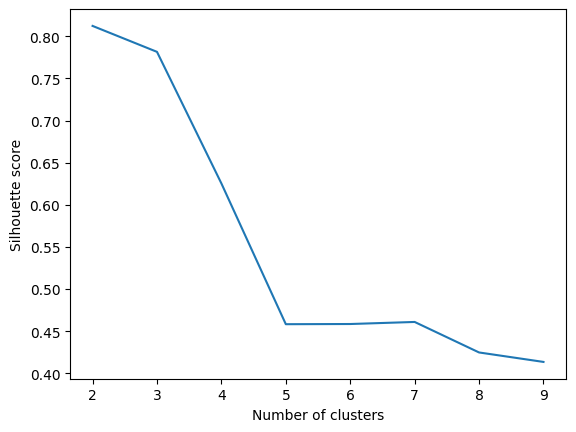

In [202]:

#calculate the silhouette score for different number of clusters on the original time series
silhouette_scores = []
for n_clusters in range(2, 10):
    km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=5, random_state=0).fit(X_std)
    silhouette_scores.append(silhouette_score(X_std, km.labels_))



 n_clusters  silhouette_score
          2          0.812281
          3          0.781509
          4          0.625345
          5          0.458336
          6          0.458559
          7          0.461002
          8          0.424799
          9          0.413574


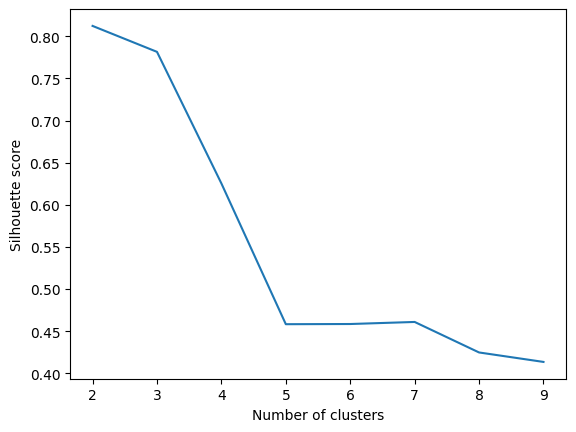

In [210]:
#print the silhouette scores with the number of clusters in a dataframe
silhouette_df = pd.DataFrame({'n_clusters': range(2, 10), 'silhouette_score': silhouette_scores})

print(silhouette_df.to_string(index=False))

#plot the silhouette scores
plt.plot(range(2, 10), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()


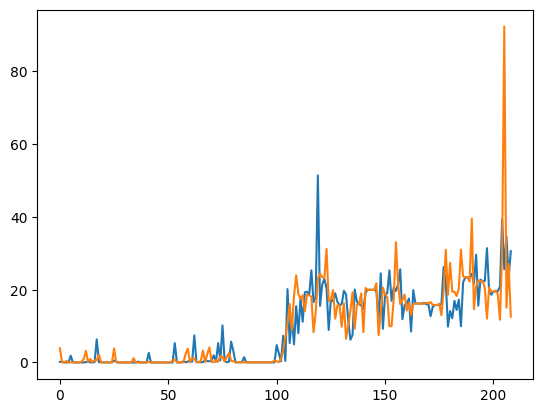

In [17]:
# Here we execute the KMeans algorithm with the optimal number of clusters based on the silhouette score on the original time series 
# The metric chosen for all the clustering algorithms is Dynamic Time Warping (DTW)

#kmeans clustering
km = TimeSeriesKMeans(n_clusters=2, metric="dtw", max_iter=5, random_state=0).fit(X_std)

plt.plot(km.cluster_centers_.reshape(X_std.shape[1], 2))
plt.show()


##### MinMax Scaled Clustering

In [22]:
#calculate the silhouette score for different number of clusters on the timeseries scaled with MinMax 
silhouette_scores = []
for n_clusters in range(2, 10):
    km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=5, random_state=0, n_jobs=-1).fit(X_minmax)
    silhouette_scores.append(silhouette_score(X_minmax, km.labels_))

#plot the silhouette scores
plt.plot(range(2, 3), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()


KeyboardInterrupt: 

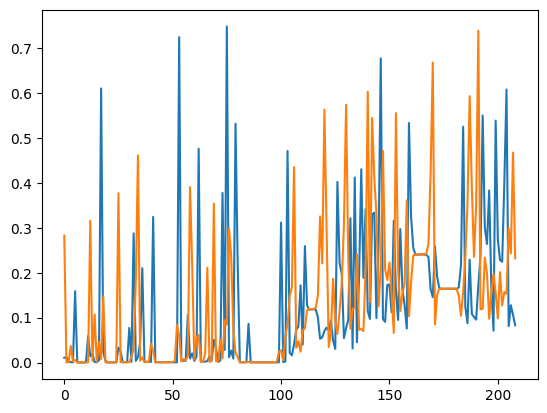

In [22]:

#kmeans clustering
km_minmax = TimeSeriesKMeans(n_clusters=2, metric="dtw", max_iter=5, random_state=0, n_jobs=2).fit(X_minmax)


plt.plot(km_minmax.cluster_centers_.reshape(X_minmax.shape[1], 2))
plt.show()


##### Standard Scaled Clustering

In [12]:


#calculate the silhouette score for different number of clusters on the timeseries scaled with Standard Scaler
silhouette_scores = []
for n_clusters in range(2, 10):
    km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=5, random_state=0).fit(X_mean)
    silhouette_scores.append(silhouette_score(X_mean, km.labels_))

#plot the silhouette scores
plt.plot(range(2, 10), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()


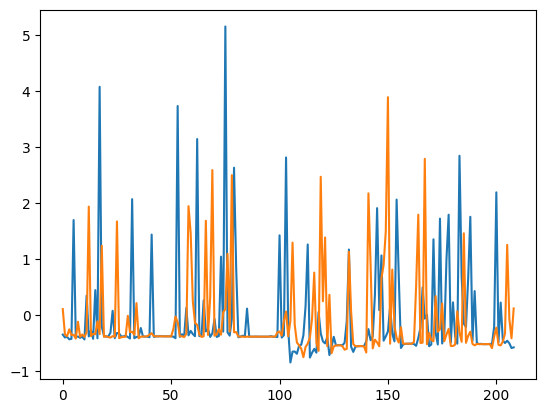

In [24]:
#kmeans clustering
km_mean = TimeSeriesKMeans(n_clusters=2, metric="dtw", max_iter=5, random_state=0, n_jobs=-1).fit(X_mean)


plt.plot(km_mean.cluster_centers_.reshape(X_mean.shape[1], 2))
plt.show()


#### 2. Feature-based Clustering

In [30]:
#define a function to extract statistical features
import scipy.stats as stats
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [24]:
#calculate the features for each time series
features_dict = {}
for city in ts_dict.keys():
    features_dict[city] = calculate_features(ts_dict[city])

features_dict['Chicago']

{'avg': 93.64497607655503,
 'std': 33.066537041084,
 'var': 1093.3958718893798,
 'med': 91.60000000000001,
 '10p': 51.06,
 '25p': 69.80000000000001,
 '50p': 91.60000000000001,
 '75p': 116.7,
 '90p': 136.08000000000007,
 'iqr': 46.89999999999999,
 'cov': 2.8320164267641474,
 'skw': -0.012781074377324026,
 'kur': -0.3459233741089207}

In [25]:
F_std = [list(calculate_features(x).values())[:-2] for x in X_std]
F_mean = [list(calculate_features(x).values())[:-2] for x in X_mean]
F_minmax = [list(calculate_features(x).values())[:-2] for x in X_minmax]


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


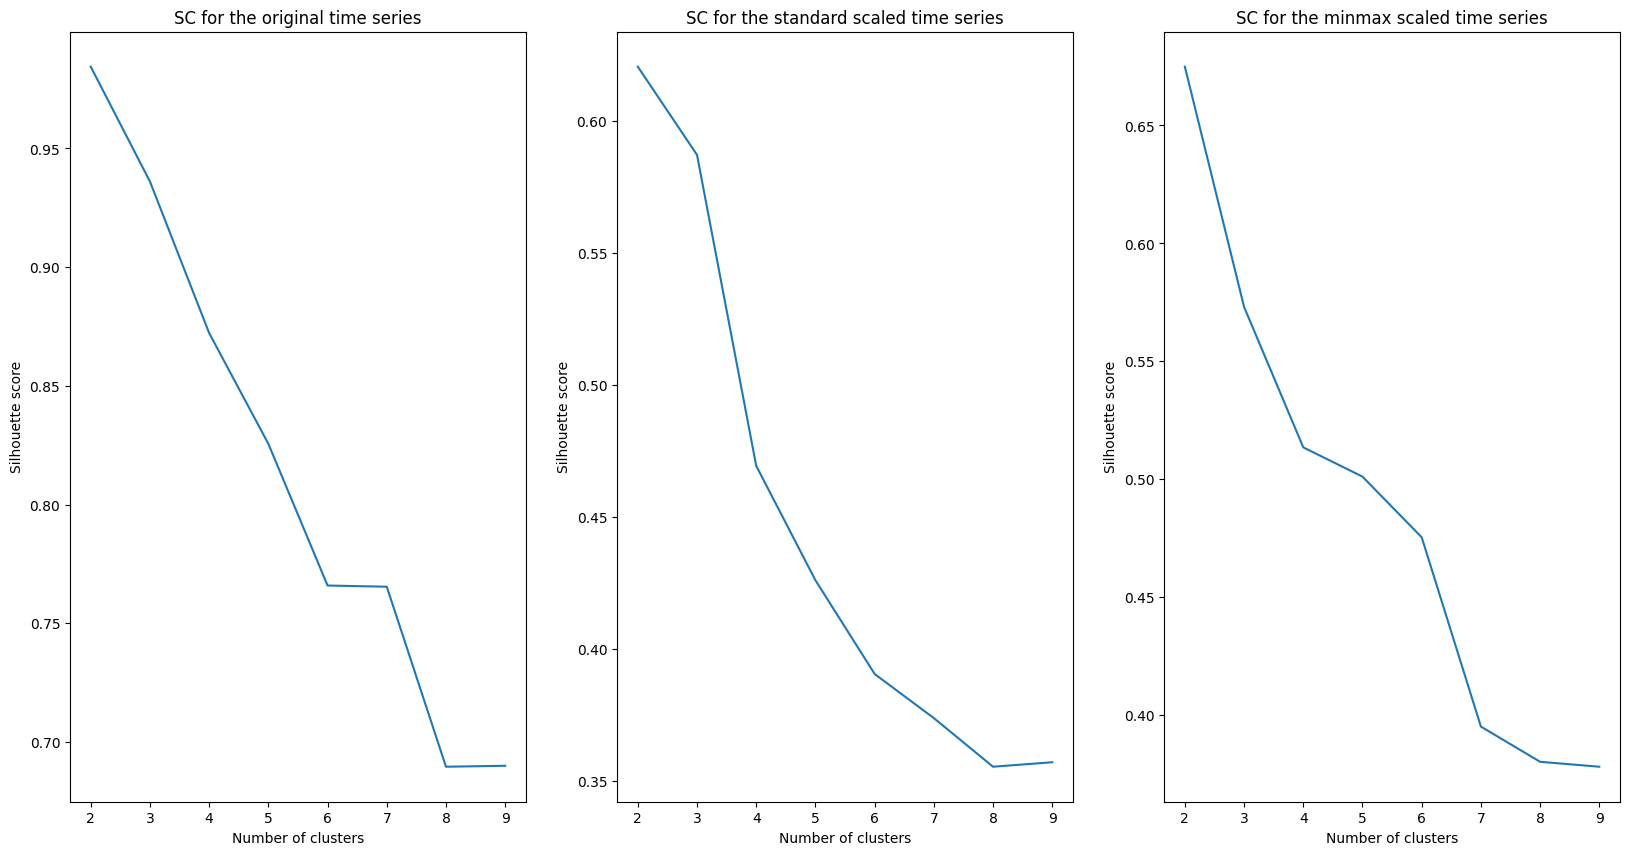

 n_clusters  silhouette_score  silhouette_score_mean  silhouette_score_minmax
          2          0.984422               0.620615                 0.674923
          3          0.936071               0.587219                 0.573063
          4          0.872255               0.469417                 0.513506
          5          0.825605               0.426069                 0.501098
          6          0.765932               0.390568                 0.475368
          7          0.765437               0.373845                 0.395098
          8          0.689629               0.355427                 0.380166
          9          0.690026               0.357124                 0.378075


In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm

k_min = 2
k_max = 10


plt.figure(figsize=(20,10))
plt.subplot(1, 3, 1)
# KMeans
scores1 = []
for k in tqdm(range(k_min, k_max)):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=42).fit(F_std)
    score1 = silhouette_score(F_std, kmeans.labels_)
    scores1.append(score1)
plt.title('SC for the original time series')
plt.plot(range(k_min, k_max), scores1)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
#plt.show()



plt.subplot(1, 3, 2)
# KMeans
scores2 = []
for k in tqdm(range(k_min, k_max)):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=42).fit(F_mean)
    score2 = silhouette_score(F_mean, kmeans.labels_)
    scores2.append(score2)
plt.title('SC for the standard scaled time series')
plt.plot(range(k_min, k_max), scores2)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
#plt.show()



plt.subplot(1, 3, 3)
# KMeans
scores3 = []
for k in tqdm(range(k_min, k_max)):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=42).fit(F_minmax)
    score3 = silhouette_score(F_minmax, kmeans.labels_)
    scores3.append(score3)
plt.title('SC for the minmax scaled time series')
plt.plot(range(k_min, k_max), scores3)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()


#print the values of the silhouette scores in a dataframe fpr the 3 different scalers one next to the other
silhouette_df = pd.DataFrame({'n_clusters': range(k_min, k_max), 'silhouette_score': scores1, 'silhouette_score_mean': scores2, 'silhouette_score_minmax': scores3})

print(silhouette_df.to_string(index=False))






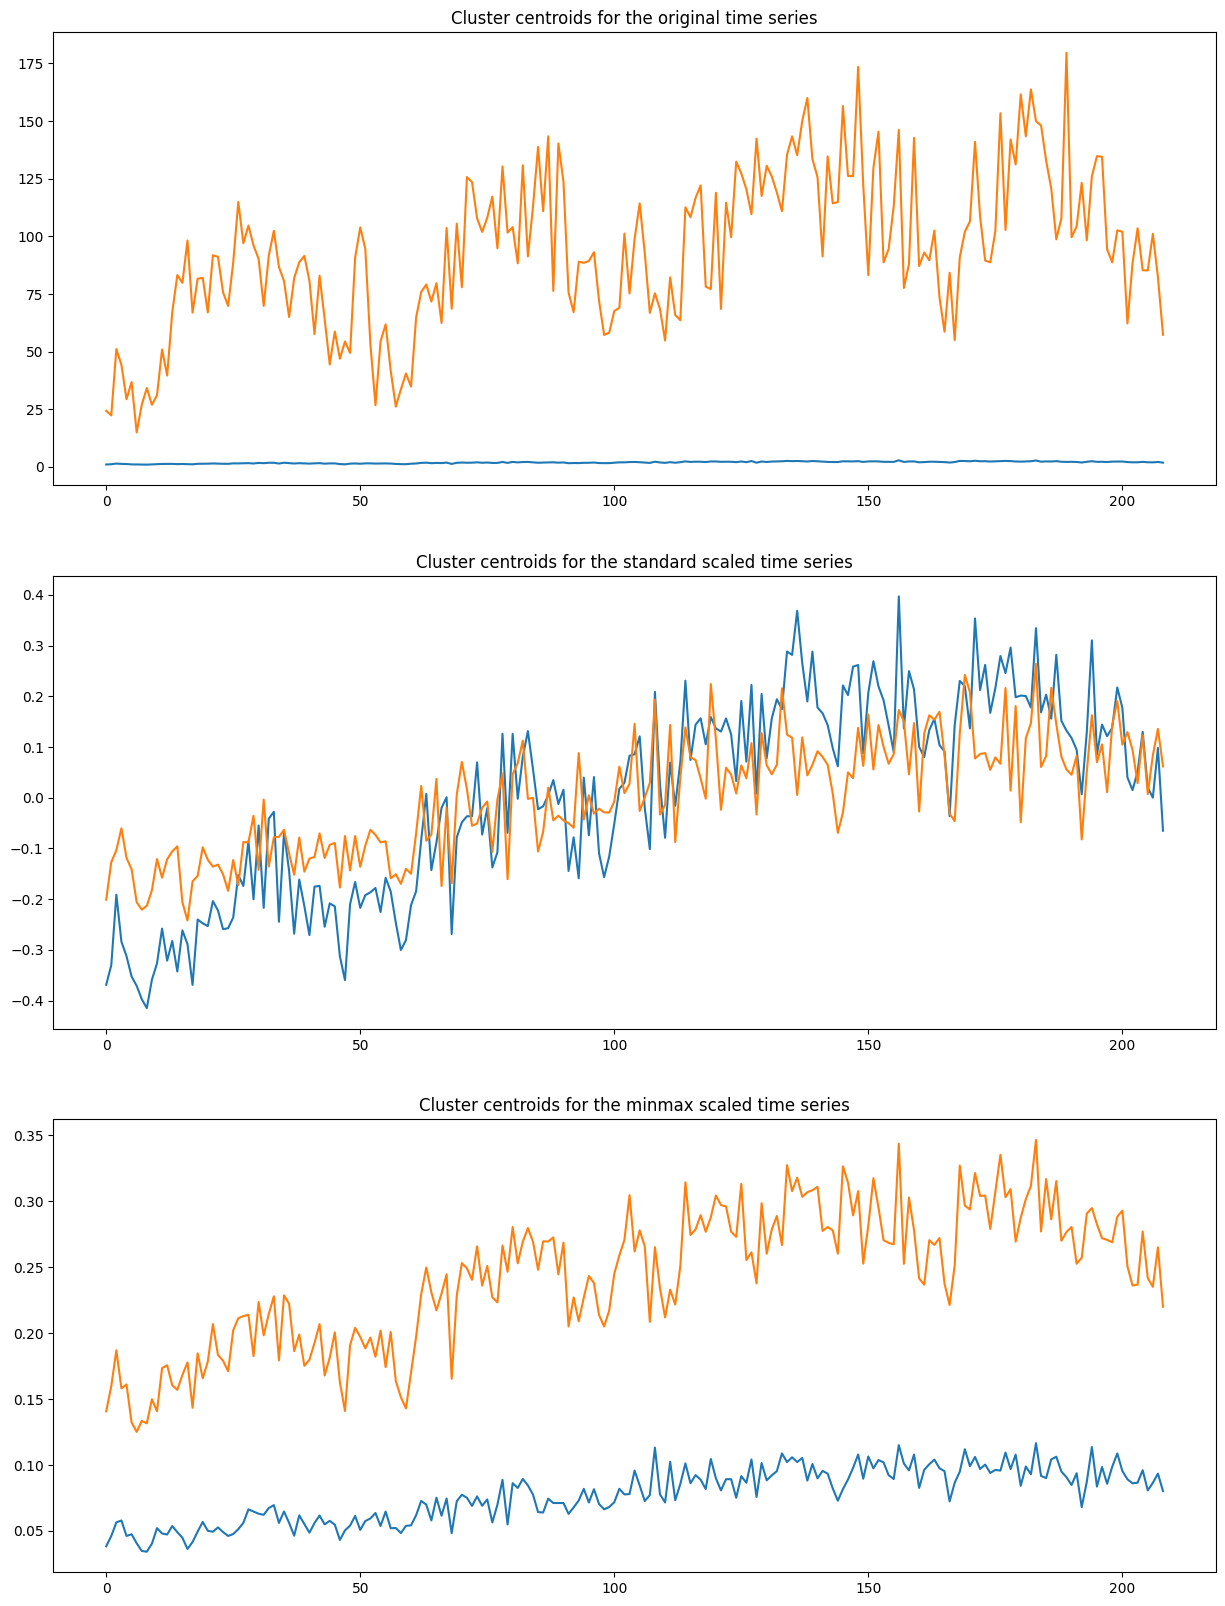

In [27]:
from sklearn.cluster import KMeans

kmeans_std = KMeans(n_clusters=2, n_init=10)
kmeans_std.fit(F_std)

kmeans_mean = KMeans(n_clusters=2, n_init=10)
kmeans_mean.fit(F_mean)

kmeans_minmax = KMeans(n_clusters=2, n_init=10)
kmeans_minmax.fit(F_minmax)



plt.figure(figsize=(15,20))

plt.subplot(3,1,1)
for i in range(2):
    plt.title('Cluster centroids for the original time series')
    plt.plot(np.mean(X_std[np.where(kmeans_std.labels_ == i)[0]], axis=0))
#plt.show()
    


plt.subplot(3,1,2)
for i in range(2):
    plt.title('Cluster centroids for the standard scaled time series')
    plt.plot(np.mean(X_mean[np.where(kmeans_mean.labels_ == i)[0]], axis=0))
#plt.show()
    


plt.subplot(3,1,3)
for i in range(2):
    plt.title('Cluster centroids for the minmax scaled time series')
    plt.plot(np.mean(X_minmax[np.where(kmeans_minmax.labels_ == i)[0]], axis=0))
plt.show()

### Comparison of the clustering methods with random walks


#### 1. Standard Clustering

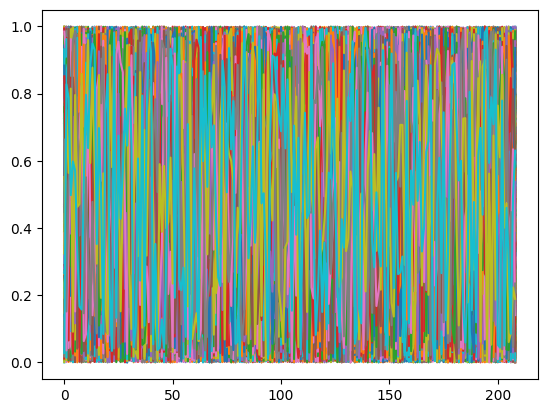

In [28]:
def generate_random_series(n_series, n_points, value_range=(0, 1)):
    # Generate random values for each point in each series
    series = np.random.uniform(value_range[0], value_range[1], size=(n_series, n_points))

    return series

# Generate 790 series of 209 points each
random_series = generate_random_series(790, 209)

# Plot the series
plt.plot(random_series.T)
plt.show()

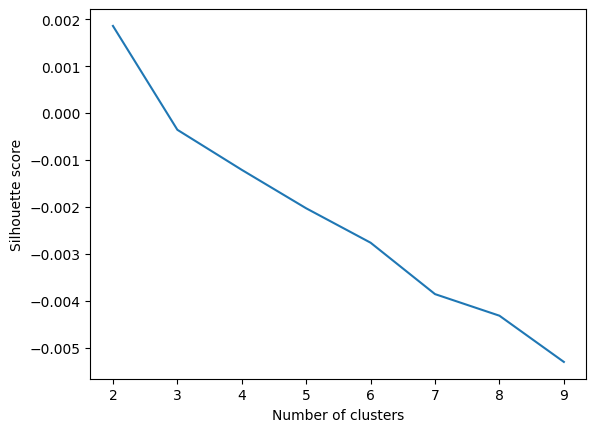

In [ ]:
#calculate the best number of cluster with the silhouette score for the random series
silhouette_scores = []
for n_clusters in range(2, 10):
    km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=5, random_state=0).fit(random_series)
    silhouette_scores.append(silhouette_score(random_series, km.labels_))

#plot the silhouette scores
plt.plot(range(2, 10), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()


In [18]:
#print silhouette scores
print(silhouette_scores[0])

NameError: name 'silhouette_scores' is not defined

#### 2. Feature-based Clustering

In [29]:
F_random_minmax = [list(calculate_features(x).values())[:-2] for x in random_series]

100%|██████████| 8/8 [00:01<00:00,  4.74it/s]


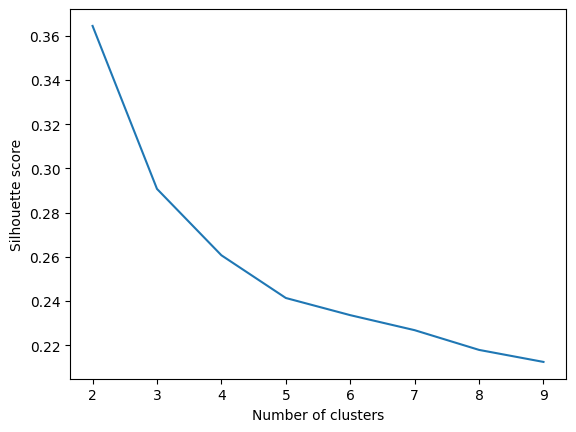

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm


k_min = 2
k_max = 10
# KMeans
scores_feature_minmax = []
for k in tqdm(range(k_min, k_max)):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=42).fit(F_random_minmax)
    score = silhouette_score(F_random_minmax, kmeans.labels_)
    scores_feature_minmax.append(score)
plt.plot(range(k_min, k_max), scores_feature_minmax)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [35]:
#print silhouette scores
print(scores_feature_minmax[0])

0.36446361343875716


---

---

## Motif Discovery


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matrixprofile.matrixProfile import stomp, mass
from matrixprofile import utils

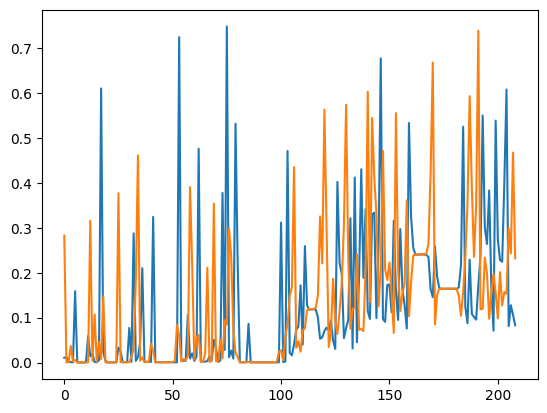

In [32]:
#We decided to choose the Timeseries to analyze as the centroids of the two clusters found with clustering

centroids = km_minmax.cluster_centers_.reshape(X_minmax.shape[1], 2).copy()

plt.plot(centroids[:,0])    
plt.plot(centroids[:,1])

plt.show()

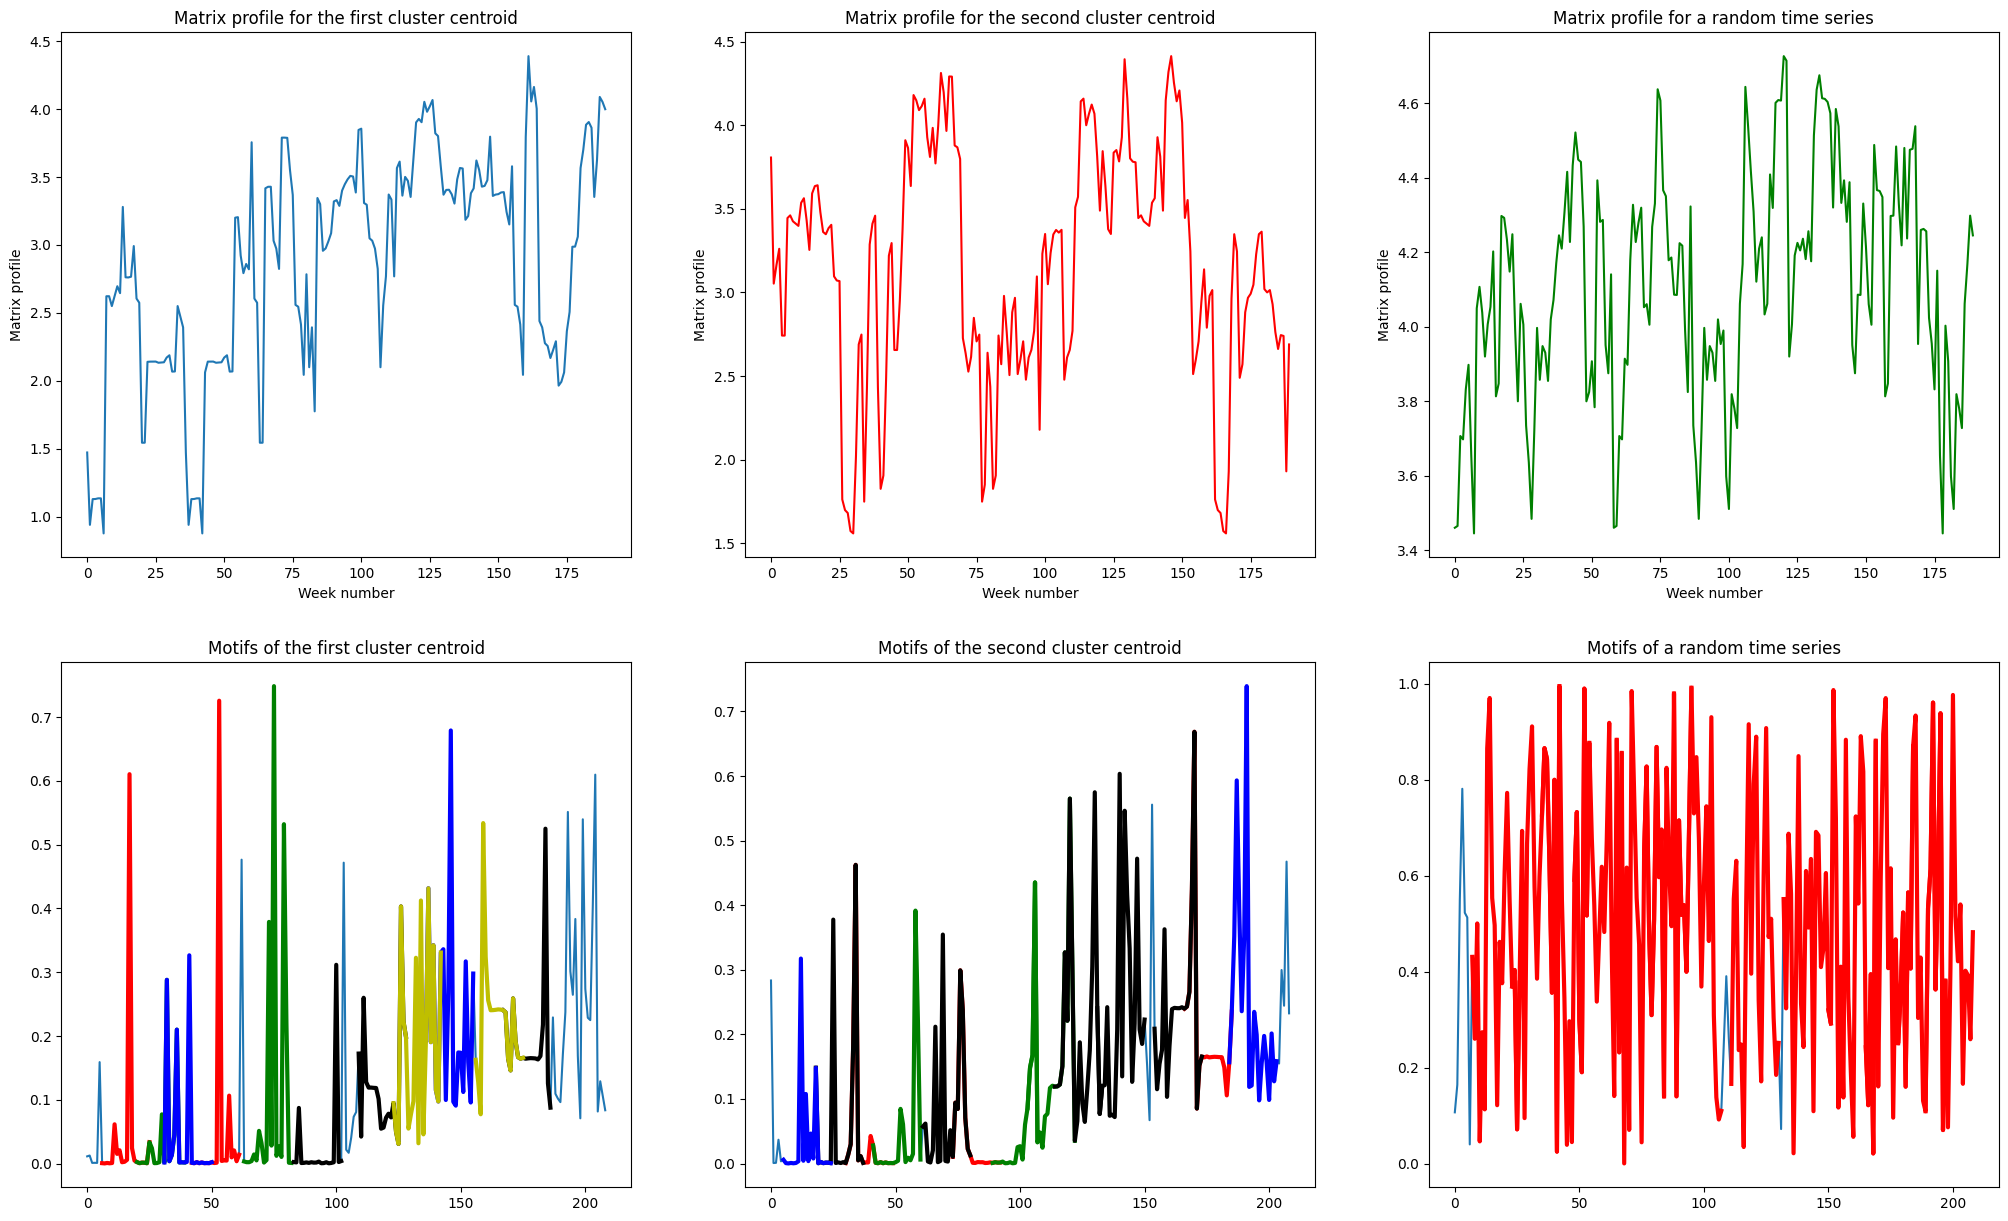

In [34]:

from importlib import reload
from matrixprofile import utils, matrixProfile
reload(utils)
reload(matrixProfile)
from matrixprofile.motifs import motifs
from matrixprofile.discords import discords

#calculate the matrix profile for the two km_minmax
centroid1 = centroids[:,0]
centroid2 = centroids[:,1]

# create a random noise ts to add to the centroids, this solves a problem in the library matrixprofile
noise = np.random.normal(0, 0.001, centroid1.shape[0])
noise = np.abs(noise)

centroid1 = centroid1 + noise
centroid2 = centroid2 + noise
random_ts = random_series[0] + noise

# window size
w = 20

# calculate the matrix profile using the STOMP algorithm
mp1, mpi1 = stomp(centroid1, w)
mp2, mpi2 = stomp(centroid2, w)
mpr, mpir = stomp(random_ts, w)

plt.figure(figsize=(25,15))

plt.subplot(2, 3, 1)
plt.title('Matrix profile for the first cluster centroid')
plt.plot(mp1)
plt.xlabel('Week number')
plt.ylabel('Matrix profile')

plt.subplot(2, 3, 2)
plt.title('Matrix profile for the second cluster centroid')
plt.plot(mp2, color='red')
plt.xlabel('Week number')
plt.ylabel('Matrix profile')

plt.subplot(2, 3, 3)
plt.title('Matrix profile for a random time series')
plt.plot(mpr, color='green')
plt.xlabel('Week number')
plt.ylabel('Matrix profile')

# calculate the motifs for the two cluster centroids and for the random time series
mo1, mod1  = motifs(centroid1, (mp1, mpi1), max_motifs=5)
mo2, mod2  = motifs(centroid2, (mp2, mpi2), max_motifs=5)
mor, modr  = motifs(random_ts, (mpr, mpir), max_motifs=5)

# Motifs plot
plt.subplot(2, 3, 4)
plt.title('Motifs of the first cluster centroid')
plt.plot(centroid1)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo1)]
for m, d, c in zip(mo1, mod1, colors):
    for i in m:
        m_shape = centroid1[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.subplot(2, 3, 5)
plt.title('Motifs of the second cluster centroid')
plt.plot(centroid2)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo2)]
for m, d, c in zip(mo2, mod2, colors):
    for i in m:
        m_shape = centroid2[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.subplot(2, 3, 6)
plt.title('Motifs of a random time series')
plt.plot(random_ts)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mor)]
for m, d, c in zip(mor, modr, colors):
    for i in m:
        m_shape = random_ts[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()


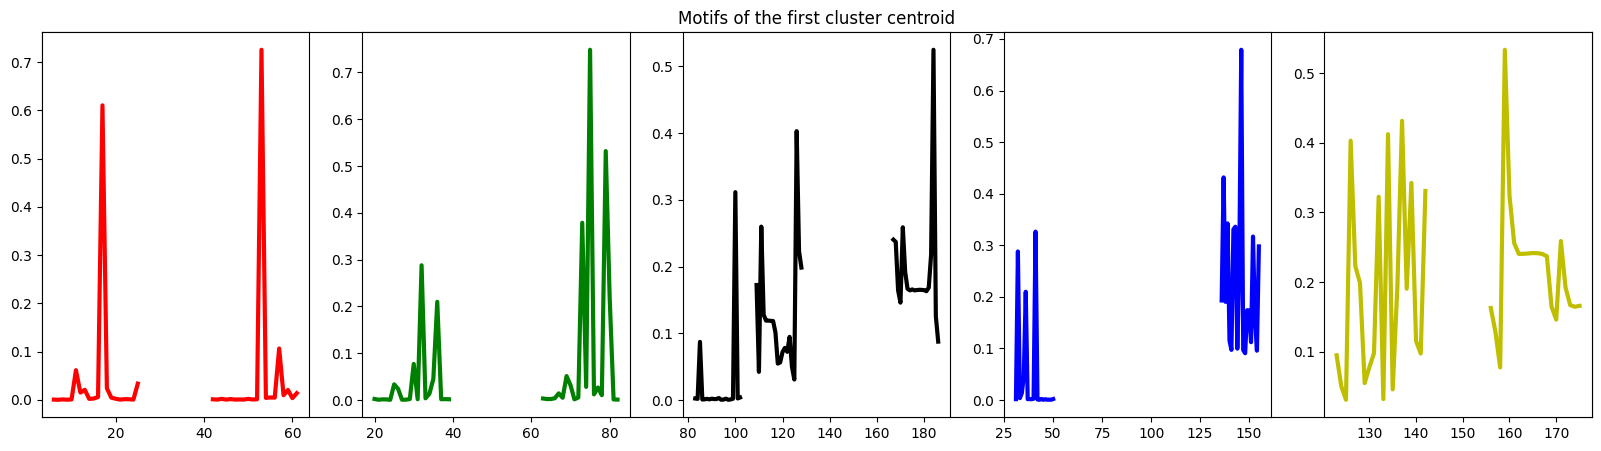

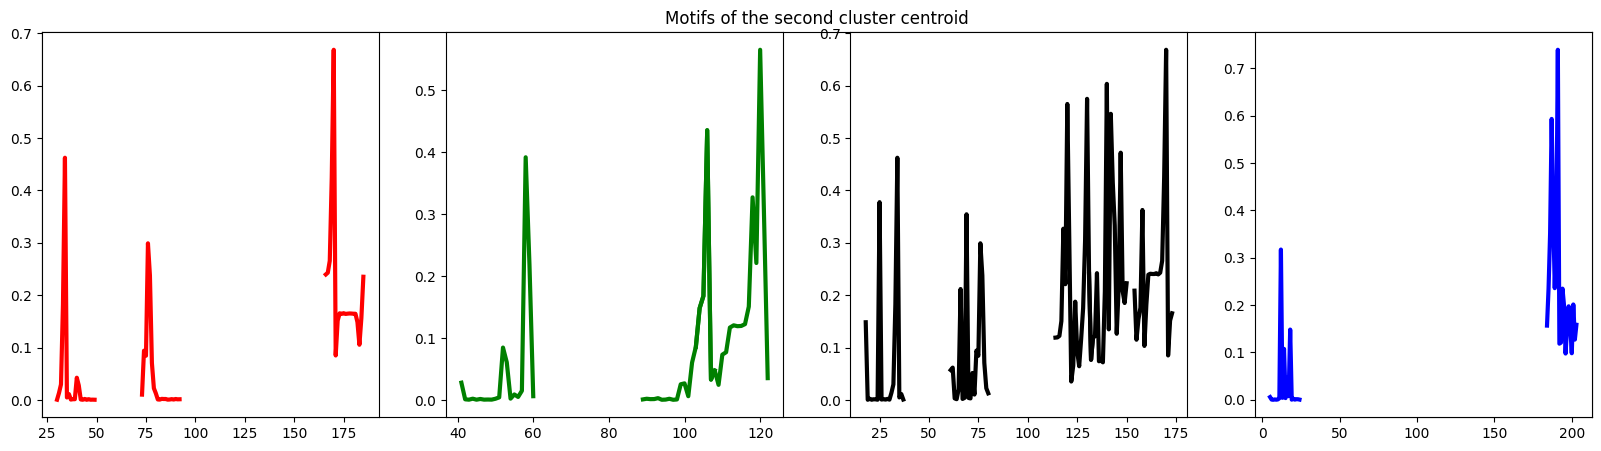

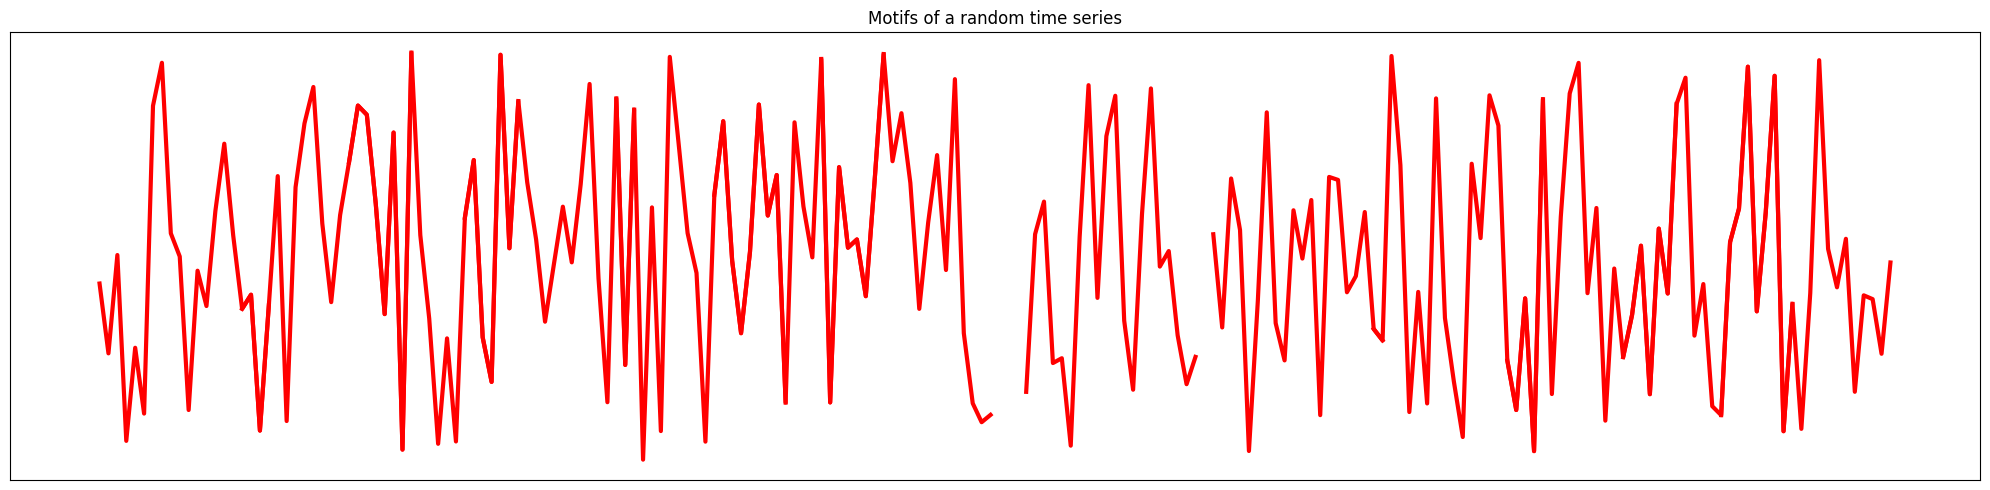

In [48]:
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo1)]
plt.figure(figsize=(20, 5))
#remove y axis
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.title('Motifs of the first cluster centroid')
for j, m, d, c in zip(range(len(mo1)), mo1, mod1, colors):
    plt.subplot(1, len(mo1), 1 + j)
    for i in m:
        m_shape = centroid1[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()



colors = ['r', 'g', 'k', 'b', 'y'][:len(mo2)]
plt.figure(figsize=(20, 5))
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.title('Motifs of the second cluster centroid')
for j, m, d, c in zip(range(len(mo2)), mo2, mod2, colors):
    plt.subplot(1, len(mo2), 1 + j)
    for i in m:
        m_shape = centroid2[i:i+w]

        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()


colors = ['r', 'g', 'k', 'b', 'y'][:len(mor)]
plt.figure(figsize=(20, 5))
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.title('Motifs of a random time series')
for j, m, d, c in zip(range(len(mor)), mor, modr, colors):
    plt.subplot(1, len(mor), 1 + j)
    for i in m:
        m_shape = random_ts[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.tight_layout()
plt.show()


---

## Anomaly detection

In [49]:
anoms_1 = discords(mp1, ex_zone=3, k=5)
anoms_2 = discords(mp2, ex_zone=3, k=5)
anoms_r = discords(mpr, ex_zone=3, k=5)

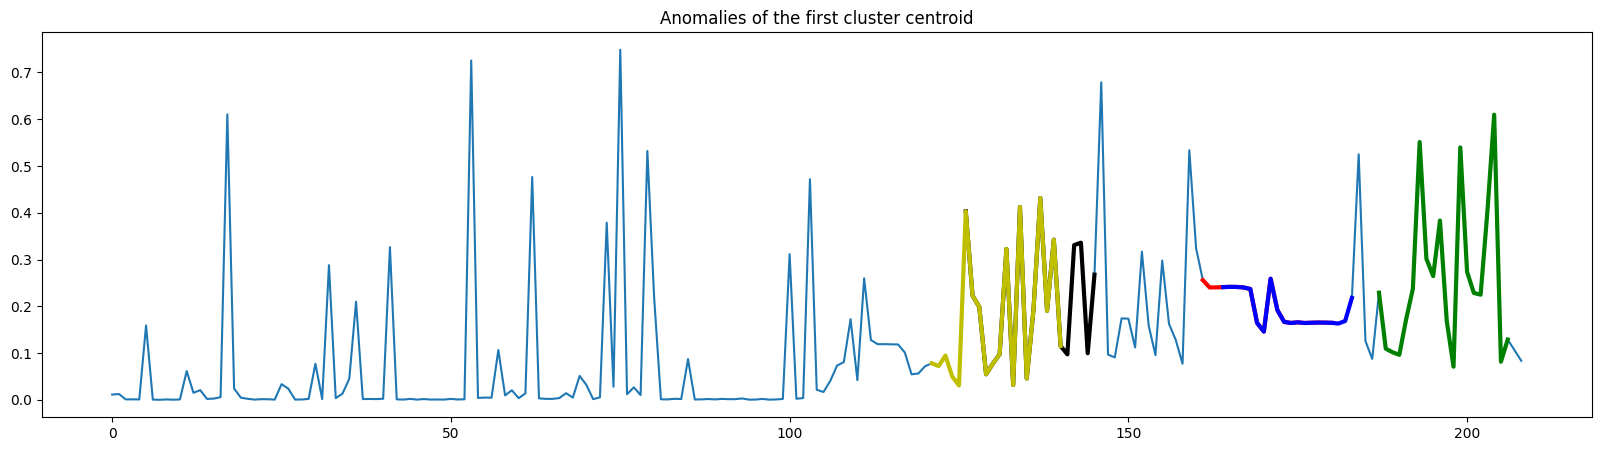

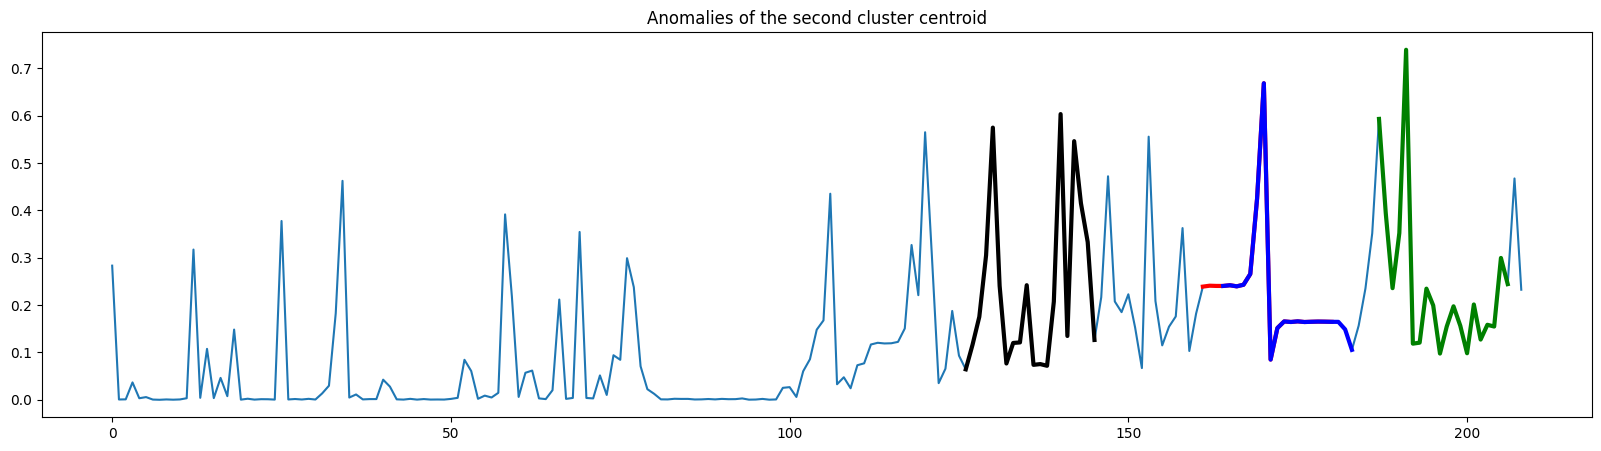

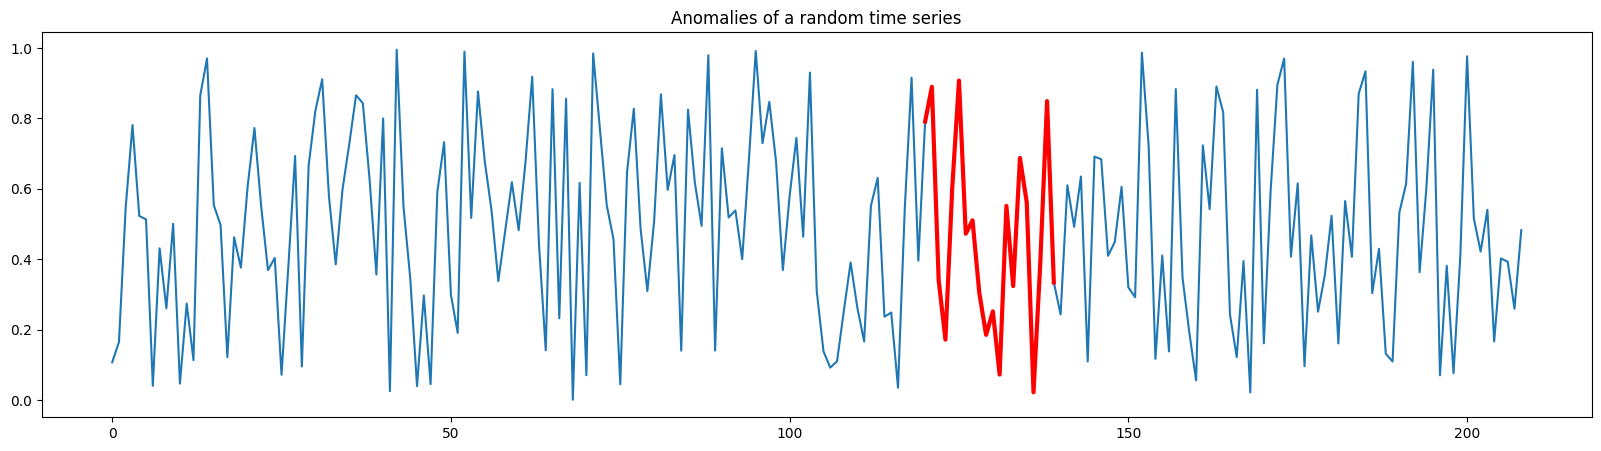

In [55]:

plt.figure(figsize=(20,5))
plt.title('Anomalies of the first cluster centroid')
plt.plot(centroid1)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo1)]
for a, c in zip(anoms_1, colors):
    a_shape = centroid1[a:a+w]
    plt.plot(range(a, a+w), a_shape, color=c, lw=3)
plt.show()


plt.figure(figsize=(20,5))
plt.title('Anomalies of the second cluster centroid')
plt.plot(centroid2)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo2)]
for a, c in zip(anoms_1, colors):
    a_shape = centroid2[a:a+w]
    plt.plot(range(a, a+w), a_shape, color=c, lw=3)
plt.show()


plt.figure(figsize=(20,5))
plt.title('Anomalies of a random time series')
plt.plot(random_ts)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mor)]
for a, c in zip(anoms_r, colors):
    a_shape = random_ts[a:a+w]
    plt.plot(range(a, a+w), a_shape, color=c, lw=3)

plt.show()